In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import boto3

In [79]:
pricing_df = pd.read_csv("../data/ec2-prices.csv")
pricing_df['price_per_ecu_on_demand'] = pricing_df['linux_on_demand_cost_hourly']/pricing_df['compute_units_ecu']
pricing_df.head()

,Name,InstanceType,memory_gb,compute_units_ecu,vcpu,gpus,fpga,enhanced_networking,linux_on_demand_cost_hourly,price_per_ecu_on_demand
0,R3 High-Memory Large,r3.large,15.25,6.5,2,0,0,Yes,0.17,0.026154
1,M4 Large,m4.large,8.00,6.5,2,0,0,Yes,0.10,0.015385
2,R4 High-Memory Large,r4.large,15.25,7.0,2,0,0,Yes,0.13,0.018571
3,C4 High-CPU Large,c4.large,3.75,8.0,2,0,0,Yes,0.10,0.012500
4,General Purpose GPU Extra Large,p2.xlarge,61.00,12.0,4,1,0,Yes,0.90,0.075000


In [80]:
pricing_df.describe()

,memory_gb,compute_units_ecu,vcpu,gpus,fpga,linux_on_demand_cost_hourly,price_per_ecu_on_demand
count,53.000000,53.000000,53.000000,53.000000,53.000000,50.000000,50.000000
mean,181.033019,65.679245,21.603774,0.603774,0.169811,2.218400,0.032753
std,333.033789,69.828436,24.473172,2.491058,1.104812,3.053673,0.025047
min,3.750000,3.000000,1.000000,0.000000,0.000000,0.070000,0.012045
25%,22.500000,14.000000,4.000000,0.000000,0.000000,0.347500,0.015595
50%,61.000000,35.000000,16.000000,0.000000,0.000000,0.980000,0.022287
75%,160.000000,99.000000,32.000000,0.000000,0.000000,2.735000,0.045246
max,1952.000000,349.000000,128.000000,16.000000,8.000000,14.400000,0.131429


In [81]:
names = pricing_df["InstanceType"].to_dict()

In [82]:
list(names.values())[0:5]

['r3.large', 'm4.large', 'r4.large', 'c4.large', 'p2.xlarge']

In [231]:
client = boto3.client('ec2')
response =client.describe_spot_price_history(InstanceTypes = list(names.values()),
        ProductDescriptions = ["Linux/UNIX"])

In [237]:
spot_price_history = response['SpotPriceHistory']
spot_history_df = pd.DataFrame(spot_price_history)
spot_history_df.SpotPrice = spot_history_df.SpotPrice.astype(float)

In [238]:
spot_history_df.head()

,AvailabilityZone,InstanceType,ProductDescription,SpotPrice,Timestamp
0,us-west-2c,m4.2xlarge,Linux/UNIX,0.1335,2017-09-10 22:41:30+00:00
1,us-west-2c,m4.2xlarge,Linux/UNIX,0.1334,2017-09-10 22:41:28+00:00
2,us-west-2c,r3.8xlarge,Linux/UNIX,0.6708,2017-09-10 22:41:27+00:00
3,us-west-2b,r3.8xlarge,Linux/UNIX,0.6684,2017-09-10 22:41:27+00:00
4,us-west-2a,r3.8xlarge,Linux/UNIX,0.6748,2017-09-10 22:41:27+00:00


In [86]:
df = spot_history_df.merge(pricing_df, how="inner", on="InstanceType")
df['price_memory_spot'] = df['SpotPrice']/df['memory_gb']
df['price_ecu_spot'] = df['SpotPrice']/df['compute_units_ecu']
df.describe()

,SpotPrice,memory_gb,compute_units_ecu,vcpu,gpus,fpga,linux_on_demand_cost_hourly,price_per_ecu_on_demand,price_memory_spot,price_ecu_spot
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.005525,125.24575,65.773000,20.354000,0.080000,0.0,1.651240,0.024225,0.004609,0.007323
std,9.549327,227.63917,55.683715,18.938779,0.635613,0.0,2.024436,0.014510,0.007786,0.033979
min,0.016200,3.75000,6.500000,2.000000,0.000000,0.0,0.100000,0.012045,0.000683,0.002137
25%,0.096700,30.00000,27.000000,8.000000,0.000000,0.0,0.420000,0.015273,0.002578,0.003454
50%,0.231300,60.00000,52.000000,16.000000,0.000000,0.0,0.850000,0.020000,0.003173,0.003801
75%,0.553900,244.00000,104.000000,32.000000,0.000000,0.0,2.130000,0.025577,0.006442,0.006388
max,144.000000,1952.00000,349.000000,128.000000,16.000000,0.0,14.400000,0.076596,0.196721,0.765957


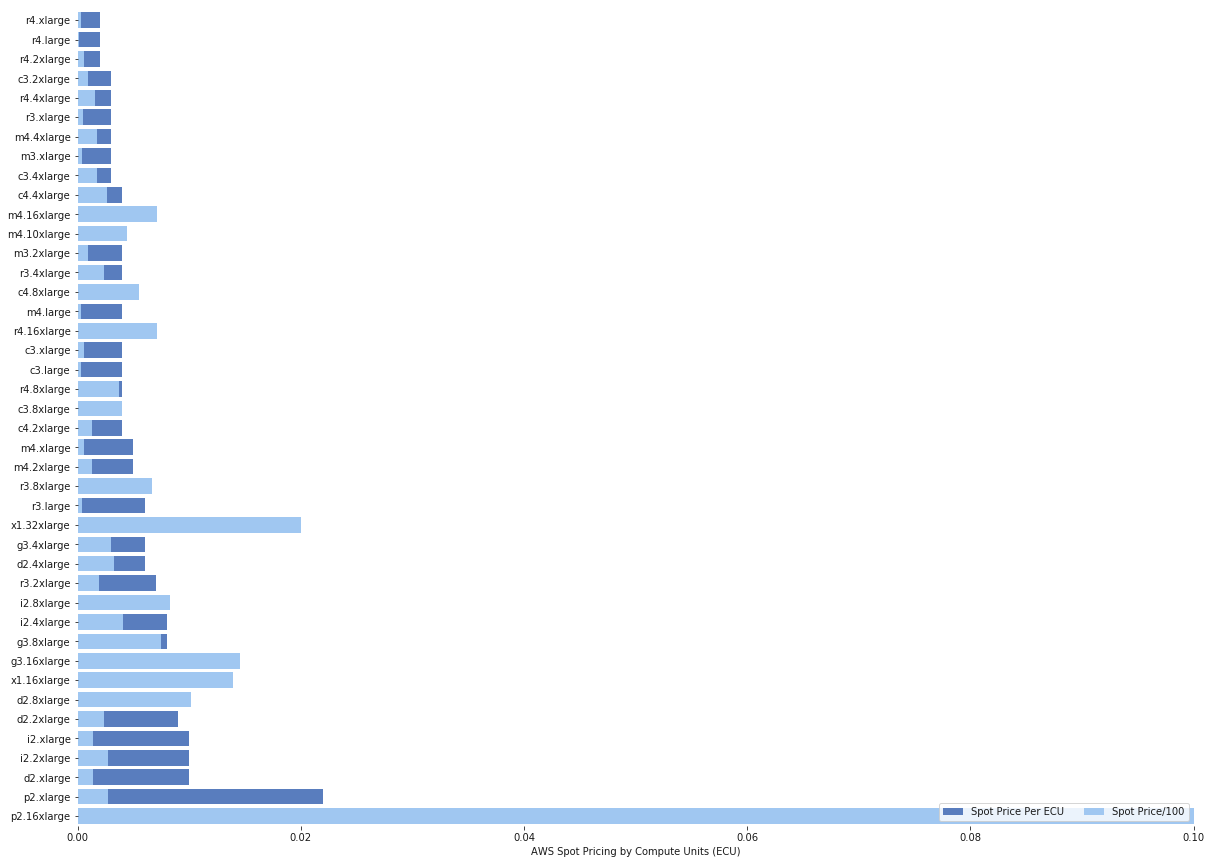

In [147]:
df_median = df.groupby("InstanceType").median()
df_median["InstanceType"] = df_median.index
df_median["price_ecu_spot"] = df_median.price_ecu_spot.round(3)
df_median["divide_SpotPrice"] = df_median.SpotPrice/100
df_median.sort_values("", inplace=True)
plt.subplots(figsize=(20,15))
ax = plt.axes()
sns.set_color_codes("muted")
sns.barplot(x="price_ecu_spot", y="InstanceType", data=df_median,
            label="Spot Price Per ECU", color="b")
sns.set_color_codes("pastel")
sns.barplot(x="divide_SpotPrice", y="InstanceType", data=df_median,
            label="Spot Price/100", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, .1), ylabel="",
       xlabel="AWS Spot Pricing by Compute Units (ECU)")
sns.despine(left=True, bottom=True)

In [208]:
numerical_df = df_median.loc[:,["price_ecu_spot", "price_memory_spot"]]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(numerical_df)
scaler.transform(numerical_df)
k_means = KMeans(n_clusters=3)
kmeans = k_means.fit(scaler.transform(numerical_df))
df_median["cluster"]=kmeans.labels_
df_median

,SpotPrice,memory_gb,compute_units_ecu,vcpu,gpus,fpga,linux_on_demand_cost_hourly,price_per_ecu_on_demand,price_memory_spot,price_ecu_spot,InstanceType,divide_SpotPrice,cluster
InstanceType,,,,,,,,,,,,,
r4.xlarge,0.03250,30.50,13.5,4,0,0,0.27,0.020000,0.001066,0.002,r4.xlarge,0.000325,0
r4.large,0.01630,15.25,7.0,2,0,0,0.13,0.018571,0.001069,0.002,r4.large,0.000163,0
r4.2xlarge,0.05910,61.00,27.0,8,0,0,0.53,0.019630,0.000969,0.002,r4.2xlarge,0.000591,0
c3.2xlarge,0.09700,15.00,28.0,8,0,0,0.42,0.015000,0.006467,0.003,c3.2xlarge,0.000970,2
r4.4xlarge,0.15570,122.00,53.0,16,0,0,1.06,0.020000,0.001276,0.003,r4.4xlarge,0.001557,0
r3.xlarge,0.04505,30.50,13.0,4,0,0,0.33,0.025385,0.001477,0.003,r3.xlarge,0.000450,0
m4.4xlarge,0.17750,64.00,53.5,16,0,0,0.80,0.014953,0.002773,0.003,m4.4xlarge,0.001775,0
m3.xlarge,0.04360,15.00,13.0,4,0,0,0.27,0.020769,0.002907,0.003,m3.xlarge,0.000436,0
c3.4xlarge,0.17850,30.00,55.0,16,0,0,0.84,0.015273,0.005950,0.003,c3.4xlarge,0.001785,2


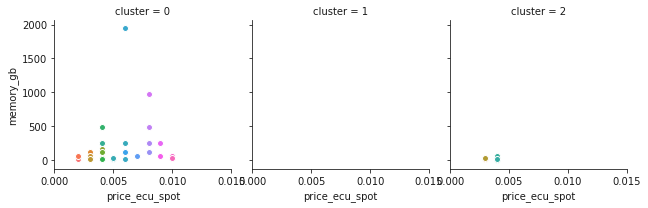

In [226]:
g = sns.FacetGrid(df_median, col="cluster",  hue="InstanceType")
g = g.map(plt.scatter, "price_ecu_spot", "memory_gb", edgecolor="w")
g.set(xlim=(0, .015))

In [230]:
df_median.groupby("cluster").median()

,SpotPrice,memory_gb,compute_units_ecu,vcpu,gpus,fpga,linux_on_demand_cost_hourly,price_per_ecu_on_demand,price_memory_spot,price_ecu_spot,divide_SpotPrice
cluster,,,,,,,,,,,
0,0.239950,64.0,47.0,16,0,0,1.14,0.024255,0.002786,0.006,0.002400
1,144.000000,732.0,188.0,64,16,0,14.40,0.076596,0.196721,0.766,1.440000
2,0.151875,22.5,43.0,12,0,0,0.61,0.015000,0.007153,0.004,0.001519


In [228]:
df_median.groupby("cluster").count()

,SpotPrice,memory_gb,compute_units_ecu,vcpu,gpus,fpga,linux_on_demand_cost_hourly,price_per_ecu_on_demand,price_memory_spot,price_ecu_spot,InstanceType,divide_SpotPrice
cluster,,,,,,,,,,,,
0,33,33,33,33,33,33,33,33,33,33,33,33
1,1,1,1,1,1,1,1,1,1,1,1,1
2,8,8,8,8,8,8,8,8,8,8,8,8
